In [ ]:
pip install mlxtend --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import chain, combinations
from tqdm import tqdm
from mlxtend.evaluate import bias_variance_decomp

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

np.random.seed(42)

%matplotlib inline
sns.set_style('darkgrid')

# 7.3

In [ ]:
X = scipy.stats.uniform.rvs(0, 1, size=(1000, 20))
X.shape

(1000, 20)

In [ ]:
y_left = (X[:,0] > 0.5).astype(int)
y_right = (np.sum(X[:,:10],axis=1) > 5).astype(int)

In [ ]:
linear_reg = LinearRegression()
knn_clf = KNeighborsClassifier()

In [ ]:
def bias_var_decomposition_reg(n_features=20):
    y_preds = np.zeros((100, 1000))
    mse_li, bias_sq_li, var_li = np.zeros(100), np.zeros(100), np.zeros(100)

    for i in range(100):
        X_sim = scipy.stats.uniform.rvs(0, 1, size=(80, 20))
        y_sim = (np.sum(X_sim[:,:10],axis=1) > 5).astype(int)

        y_pred = linear_reg.fit(X_sim[:,:n_features],y_sim).predict(X[:,:n_features])
        y_preds[i] = y_pred
        mse_li[i] = np.mean((y_right - y_pred)**2)

    y_main_preds = np.mean(y_preds, axis=0)

    bias_sq = np.mean((y_right - y_main_preds)**2)
    var = np.mean((y_preds - y_main_preds)**2)
    mse = np.mean(mse_li)

    return mse, bias_sq, var

def bias_var_decomposition_clf(n_neighbors=3):
    y_preds = np.zeros((100, 1000))

    for i in range(100):
        X_sim = scipy.stats.uniform.rvs(0, 1, size=(80, 20))
        y_sim = (X_sim[:,0] > 0.5).astype(int)

        knn_clf = KNeighborsClassifier(n_neighbors)
        y_pred = knn_clf.fit(X_sim, y_sim).predict(X)

        y_preds[i] = y_pred

    main_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=y_preds.astype(int))

    avg_expected_loss = np.apply_along_axis(lambda x: (x != y_left).mean(), axis=1, arr=y_preds.astype(int)).mean()

    avg_bias = np.sum(main_predictions != y_left) / y_left.size

    var = np.zeros(y_pred.shape)

    for pred in y_preds:
        var += (pred != main_predictions).astype(np.int_)
    var /= 100

    avg_var = var.sum() / y_left.shape[0]


    return avg_expected_loss, avg_bias, avg_var

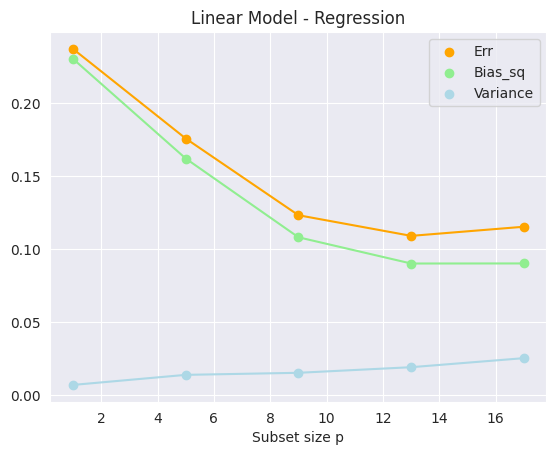

In [ ]:
reg_errs = [[] for _ in range(3)]
for n_features in range(1,21,4):
    avg_expected_loss, avg_bias, avg_var = bias_var_decomposition_reg(n_features)
    reg_errs[0].append(avg_expected_loss)
    reg_errs[1].append(avg_bias)
    reg_errs[2].append(avg_var)

plt.scatter(range(1,21,4), reg_errs[0],label='Err', color='orange')
plt.plot(range(1,21,4), reg_errs[0], color = 'orange')

plt.scatter(range(1,21,4), reg_errs[1],label='Bias_sq', color='lightgreen')
plt.plot(range(1,21,4),  reg_errs[1], color='lightgreen')

plt.scatter(range(1,21,4),  reg_errs[2],label='Variance', color='lightblue')
plt.plot(range(1,21,4),  reg_errs[2], color='lightblue')

plt.title("Linear Model - Regression")
plt.xlabel("Subset size p")
plt.legend()
plt.show()

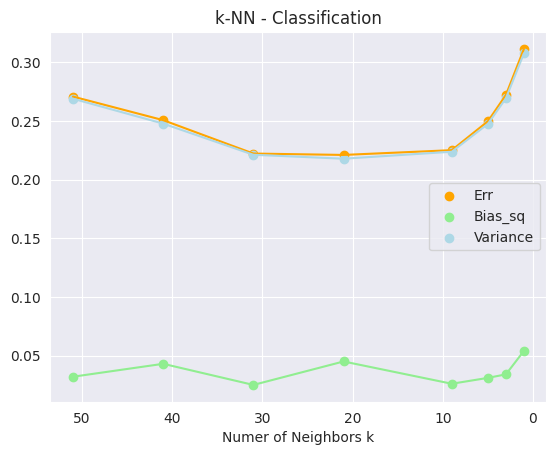

In [ ]:
clf_errs = [[] for _ in range(3)]
neighbors_candidate = [1,3,5,9,21,31,41,51]

for idx, n in enumerate(neighbors_candidate):
    err, bias_sq, var = bias_var_decomposition_clf(n)
    clf_errs[0].append(err)
    clf_errs[1].append(bias_sq)
    clf_errs[2].append(var)

plt.scatter(neighbors_candidate, clf_errs[0],label='Err', color='orange')
plt.plot(neighbors_candidate, clf_errs[0], color = 'orange')

plt.scatter(neighbors_candidate, clf_errs[1],label='Bias_sq', color='lightgreen')
plt.plot(neighbors_candidate,  clf_errs[1], color='lightgreen')

plt.scatter(neighbors_candidate,  clf_errs[2],label='Variance', color='lightblue')
plt.plot(neighbors_candidate,  clf_errs[2], color='lightblue')

plt.title("k-NN - Classification")
plt.xlabel("Numer of Neighbors k")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

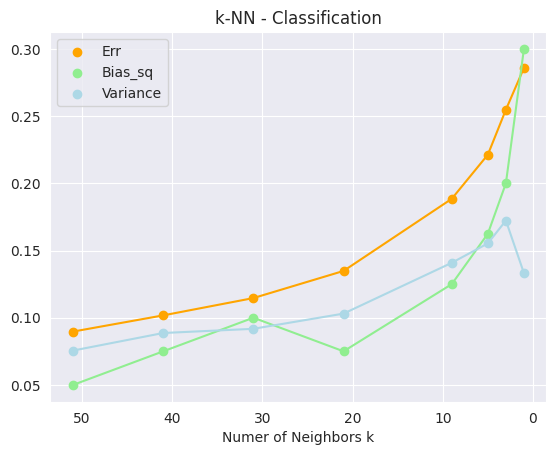

In [ ]:
xx = scipy.stats.uniform.rvs(0, 1, size=(80, 20))
yy_left = (xx[:,0] > 0.5).astype(int)
clf_errs = [[] for _ in range(3)]
neighbors_candidate = [1,3,5,9,21,31,41,51]

for idx, n in enumerate(neighbors_candidate):
    err, bias_sq, var = bias_variance_decomp(
        KNeighborsClassifier(n), X, y_left, xx, yy_left,
        loss='0-1_loss',
        random_seed=123)
    clf_errs[0].append(err)
    clf_errs[1].append(bias_sq)
    clf_errs[2].append(var)

plt.scatter(neighbors_candidate, clf_errs[0],label='Err', color='orange')
plt.plot(neighbors_candidate, clf_errs[0], color = 'orange')

plt.scatter(neighbors_candidate, clf_errs[1],label='Bias_sq', color='lightgreen')
plt.plot(neighbors_candidate,  clf_errs[1], color='lightgreen')

plt.scatter(neighbors_candidate,  clf_errs[2],label='Variance', color='lightblue')
plt.plot(neighbors_candidate,  clf_errs[2], color='lightblue')

plt.title("k-NN - Classification")
plt.xlabel("Numer of Neighbors k")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

# 7.12

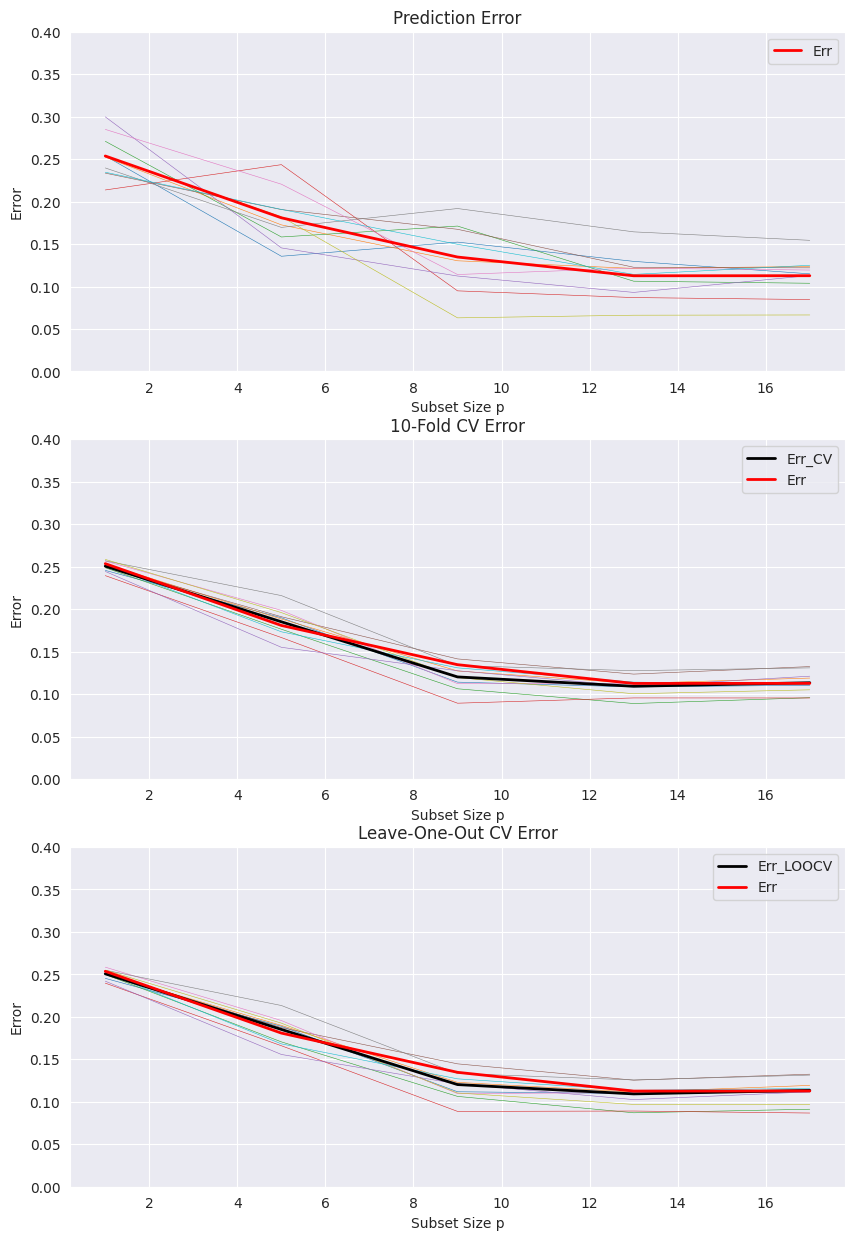

In [ ]:
total_reg_mse_li = np.zeros(5)
total_reg_cv_li = np.zeros(5)
total_reg_loocv_li = np.zeros(5)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for _ in range(100):
    X = scipy.stats.uniform.rvs(size=100).reshape(-1,1)
    for i in range(19):
        X = np.hstack([X, scipy.stats.uniform.rvs(size=100).reshape(-1,1)])

    y_right = (np.sum(X[:,:10],axis=1) > 5).astype(int)
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X,y_right, test_size=0.2, random_state=42)
    reg_mse_li, cv_mse_li, loocv_mse_li = np.zeros(5), np.zeros(5), np.zeros(5)

    for idx, n_features in enumerate(range(1,21,4)):
        y_pred_subset = linear_reg.fit(X_train_r[:, :n_features], y_train_r).predict(X_test_r[:,:n_features])
        reg_mse_li[idx] = mean_squared_error(y_test_r, y_pred_subset)

        cv_mse_li[idx] = np.mean(-cross_val_score(linear_reg, X[:, :n_features], y_right, cv=10,scoring='neg_mean_squared_error'))

        loocv_mse_li[idx] = np.mean(-cross_val_score(linear_reg, X[:, :n_features], y_right, cv=100,scoring='neg_mean_squared_error'))


    axs[0].plot(range(1, 21, 4), reg_mse_li, linewidth=0.4)
    axs[1].plot(range(1, 21, 4), cv_mse_li, linewidth=0.4)
    axs[2].plot(range(1, 21, 4), loocv_mse_li, linewidth=0.4)

    total_reg_mse_li += reg_mse_li
    total_reg_cv_li += cv_mse_li
    total_reg_loocv_li += loocv_mse_li


total_reg_mse_li /= 100
total_reg_cv_li /= 100
total_reg_loocv_li /= 100

titles = ["Prediction Error", "10-Fold CV Error", "Leave-One-Out CV Error"]

axs[1].plot(range(1,21,4), total_reg_cv_li, linewidth=2, color='black', label="Err_CV")
axs[2].plot(range(1,21,4), total_reg_cv_li, linewidth=2, color='black', label="Err_LOOCV")

for i in range(3):
    axs[i].plot(range(1,21,4), total_reg_mse_li, linewidth=2, color='red', label="Err")
    axs[i].set_ylim(0,0.4)
    axs[i].set_ylabel("Error")
    axs[i].set_xlabel("Subset Size p")
    axs[i].set_title(titles[i])
    axs[i].legend()


plt.show()